In [68]:
import torch as nn
import numpy as np
import pandas as pd
data_file = "upsampled_dataset.csv"
model_name = "upsampled_simple_model.pth"

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class SingleScoreCNN(nn.Module):
    def __init__(self):
        super(SingleScoreCNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64 * 8)  # Adjust the size based on the input size
        self.fc2 = nn.Linear(64 * 8, 64 * 2)  
        self.fc3 = nn.Linear(64 * 2, 64) 
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        x = F.sigmoid(x) # write about this in report
        return x

# Example usage:
model = SingleScoreCNN()
output = model(torch.randn(1, 3, 64, 64))  # Example input tensor (batch_size, channels, height, width)

# Define the loss and optimizer
criterion = nn.MSELoss()  # For example, if it's a regression task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MeasuresDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, indices=None):
        data = pd.read_csv(csv_file)
        if indices is not None:
            self.data = data.iloc[indices]
        else:
            self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        page = str(int(self.data.iloc[idx]['Page']))
        label = self.data.iloc[idx]['Final Score']

        img_path = os.path.join(self.image_dir, f"{page}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float), img_path

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the size expected by the network
    transforms.ToTensor()
])
# Load dataset
dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform)

# Splitting data indices for train and test
total_size = len(dataset)
testsizepercent = 0.2
test_size = int(testsizepercent * total_size)
train_size = total_size - test_size

indices = torch.randperm(total_size).tolist()
train_indices = indices[test_size:]
test_indices = indices[:test_size]

train_dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform, indices=train_indices)
test_dataset = MeasuresDataset(csv_file=data_file, image_dir='./combined', transform=transform, indices=test_indices)

# Create data loaders
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Epoch [1/5], Batch [100 / 257], MSE Loss: 0.0100
Epoch [1/5], Batch [200 / 257], MSE Loss: 0.0111
Epoch [1/5], MSE Loss: 0.0144
Epoch [2/5], Batch [100 / 257], MSE Loss: 0.0140
Epoch [2/5], Batch [200 / 257], MSE Loss: 0.0071
Epoch [2/5], MSE Loss: 0.0117
Epoch [3/5], Batch [100 / 257], MSE Loss: 0.0092
Epoch [3/5], Batch [200 / 257], MSE Loss: 0.0090
Epoch [3/5], MSE Loss: 0.0111
Epoch [4/5], Batch [100 / 257], MSE Loss: 0.0070
Epoch [4/5], Batch [200 / 257], MSE Loss: 0.0141
Epoch [4/5], MSE Loss: 0.0102
Epoch [5/5], Batch [100 / 257], MSE Loss: 0.0075
Epoch [5/5], Batch [200 / 257], MSE Loss: 0.0107
Epoch [5/5], MSE Loss: 0.0094


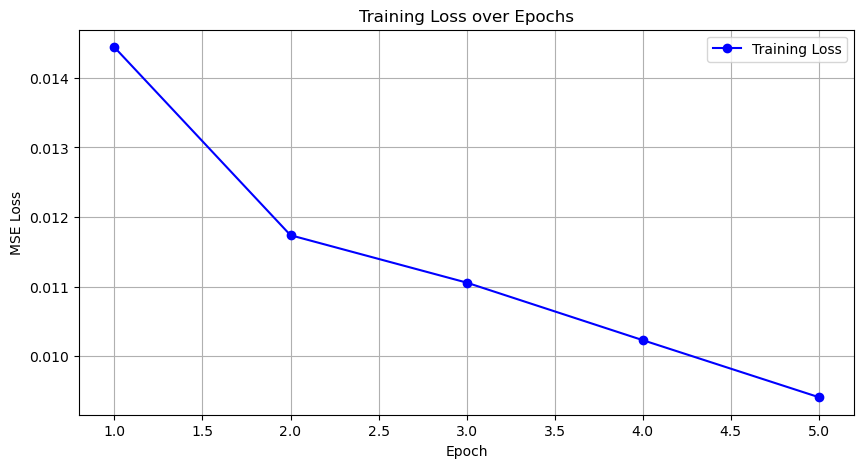

In [71]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare model, loss function, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
device = "mps"

model = model.to(device)

all_epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batches = 0
    for images, labels, img_paths in dataloader:
        batches += 1
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
        
        if batches % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batches} / {len(dataloader)}], MSE Loss: {loss.item():.4f}")
    
    # Compute and print the average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    all_epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], MSE Loss: {avg_loss:.4f}")
    
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), all_epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# torch.save(model,"simple_model.pth")

In [73]:
# model = torch.load("simple_model.pth")

In [74]:
model

SingleScoreCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

In [75]:
thresholds = [0.3, 0.4, 0.6, 0.8, 1]
def model_predict_class(image, model):
    scores = model(image)
    scores = scores.squeeze()
    # print(scores)
    categories, ss = [], []
    for score in scores:
        s = score.item()
        # print(score)
        if s <= 0.4:
            category = "Poor"
        elif 0.4 < s <= 0.6:
            category = "Fair"
        elif 0.6 < s <= 1:
            category = "Good"
        ss.append(s)
        categories.append(category)
    return categories, ss

In [76]:
device = "mps"
model = model.to(device)

In [77]:
# for images, labels, img_paths in dataloader:
#     images, labels = images.to(device), labels.to(device)
#     output, scores = model_predict_class(images, model)
#     for img_path, o, l, s  in zip(img_paths, output, labels, scores):
#         print(f"{img_path}: {o} (Predicted Score: {s}) (Label: {l.item()})")

In [78]:
import numpy as np

def get_category(s):
    if s <= 0.4:
        return "Poor"
    elif 0.4 < s <= 0.6:
        return "Fair"
    elif 0.6 < s <= 1:
        return "Good"

def model_predict_class(image, model):
    scores = model(image)
    scores = scores.squeeze()
    categories, ss = [], []
    for score in scores:
        s = score.item()
        if s <= 0.4:
            category = "Poor"
        elif 0.4 < s <= 0.6:
            category = "Fair"
        elif 0.6 < s <= 1:
            category = "Good"
        ss.append(s)
        categories.append(category)
    return categories, ss

def create_confusion_matrix(labels, predictions):
    categories = ["Poor", "Fair", "Good"]
    confusion_matrix = np.zeros((len(categories), len(categories)), dtype=int)
    for i in range(len(labels)):
        true_category = labels[i]
        pred_category = predictions[i]
        true_index = categories.index(true_category)
        pred_index = categories.index(pred_category)
        confusion_matrix[true_index][pred_index] += 1
    return confusion_matrix

from tqdm import tqdm

# Initialize lists to store labels and predictions
true_labels = []
predicted_labels = []

# Iterate through test_loader with tqdm for progress tracking
for images, labels, img_paths in tqdm(test_loader, desc='Processing Images'):
    images, labels = images.to(device), labels.to(device)
    output, scores = model_predict_class(images, model)
    # Append true labels and predicted labels from each batch
    true_labels.extend([get_category(label.item()) for label in labels])
    predicted_labels.extend(output)

# Calculate confusion matrix
conf_matrix = create_confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Processing Images: 100%|██████████| 65/65 [00:25<00:00,  2.57it/s]

Confusion Matrix:
[[166 504   9]
 [ 32 564  73]
 [  2 426 276]]


In [79]:
# Calculate confusion matrix
conf_matrix = create_confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[166 504   9]
 [ 32 564  73]
 [  2 426 276]]


In [80]:
def calculate_f1_scores(conf_matrix):
    num_classes = conf_matrix.shape[0]
    f1_scores = []

    # Calculating precision, recall, and F1 score for each class
    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        
        f1_scores.append(f1)

    return f1_scores

calculate_f1_scores(conf_matrix)

[0.3777019340159272, 0.521497919556172, 0.519774011299435]

In [81]:
from tqdm import tqdm

# Initialize list to store test losses
test_losses = []

# Set the model to evaluation mode
model.eval()

# Iterate through test_loader with tqdm for progress tracking
for images, labels, img_paths in tqdm(test_loader, desc='Processing Images'):
    images, labels = images.to(device), labels.to(device)
    # Forward pass to get outputs
    outputs = model(images)
    # Calculate loss
    loss = criterion(outputs, labels)
    # Append test loss from each batch
    test_losses.append(loss.item())

# Calculate average test loss
average_test_loss = np.mean(test_losses)

# Print average test loss
print("Average Test Loss:", average_test_loss)

Processing Images:   0%|          | 0/65 [00:00<?, ?it/s]/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Processing Images:  98%|█████████▊| 64/65 [00:24<00:00,  2.66it/s]/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Processing Images: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s]

Average Test Loss: 0.02438655011355877


In [82]:
torch.save(model,model_name)